30.07.2016, Pawel [alxd](https://alxd.org/) Chojnacki
# NeuroOn Hypnogram Analysis

Following my principles of Open Access and Open Notebook Science I'd like to present you my comparative analysis of NeuroOn and a professional polisomnograph recording from two nights. To learn more about the experiment itself, please head back to my [previous blog post](https://alxd.org/neuroon-analysis-sources.html).

*[more on NeuroOn and AURA PSG, make assumption that Aura is the closest thing to what is actually happening in the brain]*

At the moment of writing this I haven't been professionally involved in EEG analysis for over two years - please feel free to comment on my code and let me know if any part is unclear or may lead to wrong conclusions.

## Signal formats

All signals are available for download [here](https://obsidian.alxd.org/cloud/index.php/s/GvTLhgL8A7I8iTF), with md5sum `2ed8faecb52e027948f19d62175e02da`.

NeuroOn signal was obtained by using proprietary Intelclinic's scripts I am not allowed to share. They produced four CSV files, containing respectively:

 - EEG signal (125 Hz)
 - accelerometer signal
 - LED activity
 - Staging ([hypnogram](https://en.wikipedia.org/wiki/Hypnogram))

AURA PSG signal was exported to an EDF format using Grass Technologies PSG TWin 4.5.4 and 4.5.2 to minimize the risk of software-derived artifacts. The channels signals include:

 - EOG1-A1
 - EOG2-A1
 - CHIN1-CHIN2
 - CHIN2-CHIN3
 - F3-A2
 - C3-A2
 - O1-A2
 - F4-A1
 - C4-A1
 - O2-A1
 - SNORE (first night only)
 - FLOW (first night only)
 - CHEST (first night only)
 - ABDOMEN (first night only)
 - ECG (first night only)
 - SaO2 (blood oxygen saturation, first night only)
 - HR (heart rate, first night only)
 - LEG1 (first night only)
 - LEG2 (first night only)
 - Pos (first night only)

PSG signals from both nights were scored by a professional and exported to XLS and CSV files.

Since proper comparative analysis of NeuroOn's and AURA's signals would require an immense amount of work, I'd like to start with comparing their hypnograms.

In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import signal
import pandas as pd
import pyedflib as el
from datetime import datetime, timedelta
from matplotlib import pyplot as pp
import seaborn as sns
pp.rcParams['figure.figsize'] = (16.0, 8.0)

import lib.plot as libp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# first, open the AURA signal file from the first night
edf_file = el.EdfReader('night_01/psg_signal.edf')

In [97]:
# let's get EOG1-A1 signal
# edf_file.getPhysicalDimension(0) # uV - microVolts

psg_start = edf_file.getStartdatetime()
print('PSG recording started at %s' % (psg_start))

psg_signal = pd.DataFrame(edf_file.readSignal(0), columns=['signal'])
psg_signal['timestamp'] = pd.DatetimeIndex([
    psg_start + timedelta(milliseconds=(i * (1000/PSG_SAMPLE_RATE)))
    for i in np.arange(len(psg_signal))
]).tz_localize('Europe/Warsaw')

PSG recording started at 2016-06-20 22:29:48


In [93]:
PSG_SAMPLE_RATE = edf_file.getSampleFrequency(0)
print('First channel in the EDF file is %s' % (edf_file.getLabel(0)))
print('It has a frequency of %d Hz' % (PSG_SAMPLE_RATE))
print('Using %s units' % (edf_file.getPhysicalDimension(0)))
psg_signal[:1]

First channel in the EDF file is b'EOG1-A1'
It has a frequency of 200 Hz
Using b'uV' units


,signal,timestamp
0,-12,2016-06-20 22:29:48+02:00


In [94]:
# now open NeuroOn signal file
neuroon_signal = pd.read_csv('night_01/neuroon_signal.csv')
neuroon_signal['timestamp'] = neuroon_signal['timestamp'].astype(int)
neuroon_signal['timestamp'] =\
    pd.DatetimeIndex(pd.to_datetime(neuroon_signal['timestamp'], unit='ms', utc=True))\
    .tz_localize('UTC')\
    .tz_convert('Europe/Warsaw')

neuroon_start = neuroon_signal['timestamp'][0]
print('NeuroOn recording started', neuroon_start)

# now in nanoVolts, scale to microVolts
neuroon_signal['signal'] = neuroon_signal['signal'] / 1000.
neuroon_signal[:1]

NeuroOn recording started 2016-06-20 22:01:00+02:00


,timestamp,signal
0,2016-06-20 22:01:00+02:00,-32.768


In [95]:
# NeuroOn sampling rate was specified to be 125 Hz, but let's check

NEUROON_SAMPLE_RATE = len(neuroon_signal[
    neuroon_signal['timestamp'] < neuroon_signal['timestamp'][0] + timedelta(seconds=1)
])
print('NeuroOn sample rate is', NEUROON_SAMPLE_RATE)

# no_shifted_signal = neuroon_signal
# no_shifted_signal['timestamp'] = no_shifted_signal['timestamp'] + seconds_between_startdates
# no_shifted_signal = no_shifted_signal.reset_index(drop=True)

# time_difference_us = (no_shifted_signal['timestamp'][0] - psg_start).microseconds

# print('Timestamps are within', time_difference_us, 'microseconds from each other')

NeuroOn sample rate is 125


## Time synchronisation

Hypnogram comparison requires us to synchronise signals from both devices in time. With NeuroOn operating in debug mode there was no way I know of to place markers, leaving us with no easy way to sync. To counter that, for the first several minutes of PSG recording I repeatedly clenched my jaw and moved my eyebrows to introduce muscle artifacts to both signals, allowing me to synchronise both afterwards.

Luckily, the latest version of software I was given by Intelclinic supports recovering timestamps from the device, which could make the whole undertaking a lot easier. It should be enough to:

 - correlate the signals using [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation)
 - adjust or remove hypnogram datapoints outside of common recording time

Knowing that we are dealing with signals from two very different sources it may be reasonable not to assume a priori that the timestamps are correct and check it.

At this point it's important to remember that the devices recorded signal with different sampling rate, `125 Hz` for NeuroOn and `200 Hz` for AURA.

In [96]:

print('We need to adjust the NeuroOn signal %s' % (psg_start - neuroon_start))

TypeError: Timestamp subtraction must have the same timezones or no timezones

If NeuroOn timestamps are right, it started recording about 28 minutes before the PSG.

It seems that NeuroOn cannot handle all the muscle artifacts from the very first minutes of the experiment. Let's try to shift it 10 minutes and see if the signal makes sense then.

In [25]:
# libp.plot_signal_fragment(
#     no_shifted_signal, psg_signal,
#     shift=3600
# )

While much clearer, NeuroOn's signal doesn't look similar to Aura's. We shouldn't trust just naked eye (amplitude/time) comparisons, let's try [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) analysis (frequency/time).

In [26]:
# libp.plot_spectrum_fragment(
#     no_shifted_signal, psg_signal, seconds=5,
#     shift=600
# )

NeuroOn signal is noisy, let's try too zoom at the first 40Hz of the spectrum.

In [27]:
# libp.plot_spectrum_fragment(
#     no_shifted_signal, psg_signal, seconds=5,
#     shift=0, cap_frequency=30
# )

In [28]:
# libp.plot_spectrum_fragment(
#     no_shifted_signal, psg_signal, seconds=5,
#     shift=3600, cap_frequency=30
# )

This looks very different, NeuroOn signal is much more scattered all along the spectrum even without muscle artifacts around. I'd love to see some proper spectrograms of both signals.

## Cross correlation

Let's try to cross-correlate the signals
 - https://stats.stackexchange.com/questions/16121/for-two-offset-sampled-data-series-what-is-the-best-estimate-of-the-offset-betw/16280#16280
 - https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
 - https://en.wikipedia.org/wiki/Cross-correlation


In [12]:
# To get cross correlation, we need signals of the same length === the same sampling frequency
# ASSUMPTION: Upsampling with a Fourier method does not affect cross-correlation
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html
# Cross-correlation of 1D signals using
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html

# ASSUMPTION: Since to sync signals we want to check cross-correlation in domain of timeshift
# We may actually cut a ASSUMPTION: hour-long sample from both of the signals and try to correlate it
# in #ASSUMPTION one-minute intervals

# 0. Take 2-hour sample
# 1. Upsample it
# 2. Start cutting an hour-long sample with timeshift of 1 minute (or 1 second)
# 3. Plot it, find max

c_sample_length = timedelta(hours=2)
# Let's take a piece of signal one hour in, with less muscle artifacts
c_signal_shift = timedelta(hours=1)
c_neuroon_time_window = np.logical_and(
    neuroon_signal['timestamp'] > neuroon_signal['timestamp'][0] + c_signal_shift,
    neuroon_signal['timestamp'] <= neuroon_signal['timestamp'][0] + c_signal_shift + c_sample_length
)
c_neuroon_signal = neuroon_signal[c_neuroon_time_window]

c_psg_time_window = np.logical_and(
    psg_signal['timestamp'] > psg_signal['timestamp'][0] + c_signal_shift,
    psg_signal['timestamp'] <= psg_signal['timestamp'][0] + c_signal_shift + c_sample_length
)
c_psg_signal = psg_signal[c_psg_time_window]

# Lengths of both the windows should differ
print(len(c_neuroon_signal), len(c_psg_signal))

900000 1440000


In [13]:
# Now there's a choice: do we want to upsample NeuroOn signal to PSG signal - 125 to 200 Hz,
# further diminishing its quality, or upsample BOTH signals, risking quality loss in both of them
# ASSUMPTION: It's better to upsample both to 1 kHz = 3600 * 1000 samples
# Watch for aliasing :<

upsample_length = 7200 * 1000

c_upsampled_neuroon = signal.resample(c_neuroon_signal['signal'], upsample_length)
c_upsampled_psg = signal.resample(c_psg_signal['signal'], upsample_length)

# The lengths should now be the same
print(len(c_upsampled_neuroon) == len(c_upsampled_psg))

True


In [14]:
# First try at auto-correlation
# Assuming shift only in positive numbers (PSG after NO signal)

def correlate_with_time_shift(
    first_signal, second_signal,
    max_shift=3600, window_length=3600,
    frequency=1000, time_shift=0
):
    correlation_array = np.zeros(max_shift)
    for i in range(max_shift):
        correlation = np.correlate(
            first_signal[(i+time_shift)*frequency:(i+window_length+time_shift)*frequency],
            second_signal[time_shift:(time_shift+window_length)*frequency]
        )
        correlation_array[i] = correlation
    return correlation_array

c_array = correlate_with_time_shift(c_upsampled_neuroon, c_upsampled_psg)
# TODO:
# Write a function to cross-correlate signals with 1-min or 1-sec steps

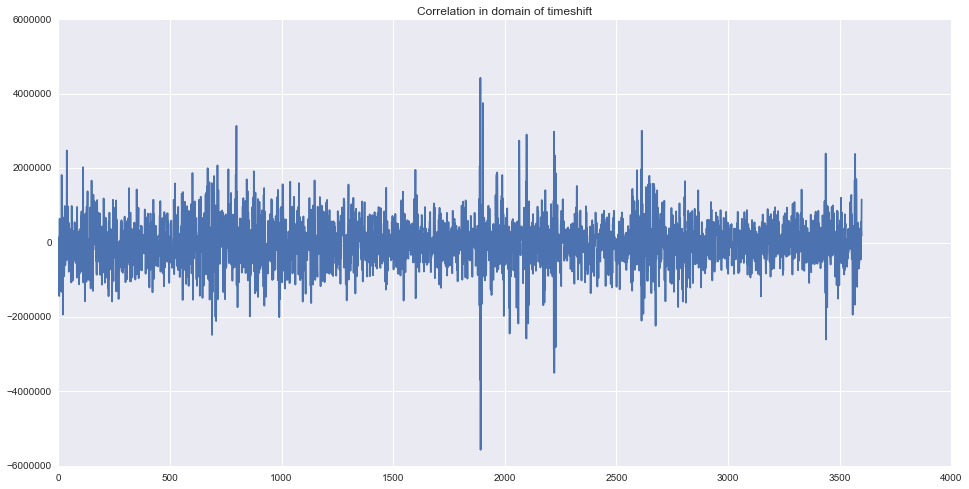

In [15]:
pp.plot(np.arange(3600), c_array)
pp.title('Correlation in domain of timeshift')
pp.show()

In [33]:
# Let's find max and "zoom" on it, trying to adjust the code better
correlation_max = np.argmax(c_array)
print('It seems that PSG signal is shifted from NeuroOn by', correlation_max, 'seconds')
# Let's check with 100Hz acurracy

It seems that PSG signal is shifted from NeuroOn by 1891 seconds


In [34]:
# c_array_100 = correlate_with_time_shift(
#     c_upsampled_neuroon, c_upsampled_psg,
#     frequency=100,
#     time_shift=correlation_max * 10 - 200, #1891 seconds - 20 seconds * 10
#     max_shift=400
# )

In [35]:
# pp.plot(np.arange(18710, 19110), c_array_100)
# pp.title('Zooming on correlation in domain of timeshift')
# pp.show()

In [59]:
# no_correlated_signal = neuroon_signal[
#     neuroon_signal['timestamp'] > neuroon_signal['timestamp'][0] + timedelta(seconds=int(correlation_max))
# ]
no_correlated_signal = neuroon_signal
no_correlated_signal['timestamp'] = no_correlated_signal['timestamp'] + timedelta(seconds=int(correlation_max))
# no_correlated_signal = no_correlated_signal.reset_index(drop=True)

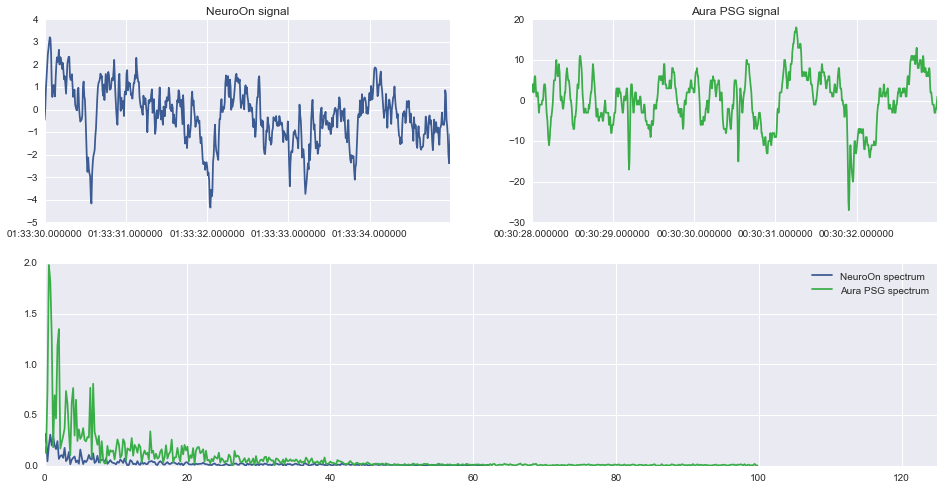

In [61]:
plot_spectrum_fragment(
    no_correlated_signal, psg_signal, seconds=5,
    shift=7240, cap_frequency=125
)

This doesn't make much sense when it comes to correlation

**TODO**:
 - [windowing](https://en.wikipedia.org/wiki/Window_function)
 - Fourier binning
 
**ONLY DIRTY NOTES BELOW**

In [ ]:
# And now something totally different
# Let's get the staging

neuroon_stages = pd.read_csv('night_01/neuroon_stages.csv')
neuroon_stages.drop('Unnamed: 0', 1, inplace=True)
neuroon_stages['timestamp'] = neuroon_stages['timestamp'].astype(int)
neuroon_stages['timestamp'] = pd.to_datetime(neuroon_stages['timestamp'], unit='ms')
neuroon_stages['timestamp'] += timedelta(hours=2)
neuroon_stages[:10]

In [ ]:
# plotting NeuroOn's stages

pp.plot(neuroon_stages['timestamp'], neuroon_stages['stage'])
pp.ylim(-5, 1)
pp.yticks(range(-5, 2), ['', 'Stage 3', 'Stage 2', 'Stage 1', 'REM', 'awake'])
pp.show()

In [ ]:
# get signal from PSG

psg_stages = pd.read_csv('night_01/psg_stages.csv', names=['timestamp', 'raw'])
psg_stages['timestamp'] = psg_stages['timestamp']
psg_stages['timestamp'] = pd.to_datetime(psg_stages['timestamp'], format=' %H:%M:%S.%f')
psg_stages[:10]

# clear the data!

In [ ]:
# fix the date problem, it will be painful for plotting
def split_days(timestamp):
    stage_timedelta = datetime(year=2016, month=6, day=20) - datetime(year=1900, month=1, day=1)
    if timestamp.hour > 12:
        return timestamp + stage_timedelta
    else:
        return timestamp + stage_timedelta + timedelta(days=1)

psg_stages['timestamp'] = psg_stages['timestamp'].apply(split_days)

In [ ]:
def clear_psg_stages(stage_desc):
    return {
        'Stage - W': 0,
        'Stage - R': -1,
        'Stage - N1': -2,
        'Stage - N2': -3,
        'Stage - N3': -4,
    }.get(stage_desc, 1)

psg_stages['stage'] = psg_stages['raw'].apply(clear_psg_stages)
psg_stages[100:110]

In [ ]:
# EXTREMELY FUGLY DO NOT DO THAT JUST FOR TESTS
psg_stages['stage'] = psg_stages['stage'].apply(lambda x: x if x < 1 else None)
new_timestamps = pd.date_range(
    psg_stages.timestamp.min(),
    psg_stages.timestamp.max(),
    freq='30s'
)
new_series = pd.DataFrame(new_timestamps, columns=['timestamp'])
# WARNING: Mutating psg_stages!
psg_stages = pd.merge(psg_stages, new_series, how='outer', on=['timestamp'])
psg_stages = psg_stages.sort_values(['timestamp'])

In [ ]:
psg_stages = psg_stages.fillna(method='backfill')
psg_stages[100:110]

In [ ]:
pp.plot(psg_stages['timestamp'], psg_stages['stage'])
pp.ylim(-5, 1)
pp.yticks(range(-5, 2), ['', 'Stage 3', 'Stage 2', 'Stage 1', 'REM', 'awake'])
pp.show()

In [ ]:
# TODO: Add missing date points
# psg_stages[psg_stages['timestamp'] > datetime(year=2016, month=6, day=21, hour=0, minute=30)]

In [ ]:
# finally, PSG / Neuroon

psg_stages_graph = pp.plot(
    psg_stages['timestamp'],
    psg_stages['stage'],
    sns.xkcd_rgb['medium green'],
    label='PSG stages'
)
neuroon_stages_graph = pp.plot(
    neuroon_stages['timestamp'],
    neuroon_stages['stage'],
    sns.xkcd_rgb['denim blue'],
    label='NeuroOn stages'
)
pp.ylim(-5, 1)
pp.yticks(range(-5, 2), ['', 'Stage 3', 'Stage 2', 'Stage 1', 'REM', 'awake'])
pp.legend()
pp.show()

I will need to clean that up.

Special thanks to: Bartosz Król, [Jarek Hirniak](http://hirniak.com/), Adam Goliński, Karolina Stosio